## Brief background
I have a house, and I need to improve the heating/cooling in it. As I go through this series, I'll go into more detail. However, the short version is that my house is a long, narrow house, and the air return is:

1. Not well located.
2. Not able to draw from one end of the house.

I figure I can use my physics brain, and a little code to figure out how to solve this problem. So I'm going to spend some time figuring out how to implement the heat equation with appropriate boundary conditions applying them to scenarios that are progressively more complex, until I feel that I can apply them to my own house.

## Heat Equation
The heat equation is:

$$
\frac{\partial u}{\partial t} = \alpha \nabla^2u
$$

where $u = u(x,y,z,t)$ is a function describing the temperature at every point in space and time in the region of interest and $\alpha$ is the Thermal Diffusivity of the material (which can depend on position as well).  There are many boundary conditions that can be applied, but I will apply _Robin Conditions_:

$$
k \left. \frac{\partial u}{\partial n}\right|_{\Omega} = h \left(u(\Omega,t) - v(\Omega, t)\right)
$$

Here $n$ is the direction of the outward normal of the boundary surface, $\Omega$ indicates spatial points on the boundary surface, $k$ is the thermal conductivity, $h$ is the heat transfer coefficient, and $v$ is the temperature on the other side of the boundary.

## Simple system
Not to be gross, but, I'll model the "punishment box" from a [Star Trek DS9 episode entitled *Paradise*](https://memory-alpha.fandom.com/wiki/Paradise_(episode)), used by a group of people who aren't half as enlightened as they think they are. I can model this as a box with length $L$, width $W$, and height $H$. I'll orient my coordinate system so that the origin is in a lower corner and $0\leq x\leq L$, $0\leq y \leq W$, and $0\leq z \leq H$.  Working in Cartesian coordinates, the heat equation becomes:

$$
\frac{\partial u}{\partial t} = \alpha \left(\frac{\partial^2 u}{\partial x^2} +
\frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2}\right)
$$

### Applying the finite difference method to $\dot{u} = \alpha\nabla^2u$

I will be applying numerical methods, and will therefore replace continuous $x,y,z,t$ values with discrete values as follows:

$$
\begin{align*}
x_i &= i \Delta x \\
y_j &= j \Delta y \\
z_k &= k \Delta z \\
t_l &= l \Delta t \\
\end{align*}
$$
I will also shorten the notation for the function $u$ as follows:

$$
u(x_i,y_j,z_k,t_l) = u^l_{ijk}
$$

I will apply the [finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to find the derivatives:
$$
\begin{align*}
\frac{\partial u}{\partial t} &= \frac{u^{l+1}_{ijk} - u^{l}_{ijk}}{\Delta t} \\
\frac{\partial u}{\partial x} &= \frac{u^l_{i+1 jk}-u^l_{ijk}}{\Delta x}   \\
\frac{\partial^2 u}{\partial x^2} &= \frac{u^l_{i+1 jk} - 2 u^l_{ijk} + u^l_{i-1 jk}}{\Delta x^2}
\end{align*}
$$
The spatial derivatives in $y$ and $z$ are similar in structure. If we choose $\Delta x = \Delta y = \Delta z$, we can plug this all in to the heat equation to find:
$$
u^{l+1}_{ijk} = u^l_{ijk} + \frac{\alpha \Delta t}{\Delta x^2}
    \left(u^l_{i+1 jk} + u^l_{i-1 jk} + u^l_{ij+1k} + u^l_{ij-1k} + u^l_{ijk+1} + u^l_{ijk-1} - 6 u^l_{ijk} \right)
$$

Basically, this equation gives us a method for finding the temperature after a time step given the temperature at the previous time step.  I will define the dimensionless constant 

$$
\gamma = \frac{\alpha \Delta t}{\Delta x^2}
$$
so we finally obtain:
$$
u^{l+1}_{ijk} = u^l_{ijk} + \gamma \left(u^l_{i+1 jk} + u^l_{i-1 jk} + u^l_{ij+1k} + 
      u^l_{ij-1k} + u^l_{ijk+1} + u^l_{ijk-1} - 6 u^l_{ijk} \right)
$$
### Applying the Finite difference method to the boundary condition
The previous equation is great, except that it won't work at the boundary. For example, if $i=0$, $u^l_{-1jk}$ is not defined.  So let's consider the boundary condition. For example on the surface where $x=0$ (or $i=0$), the outward normal direction is in the $-x$ direction:
$$
\left. k\frac{\partial u}{\partial x}\right|_{x=0} = h(u(x=0,y,z,t) - v(x=0,y,z,t))
$$
Convert this to the index notation and apply the finite difference method:
$$
u^l_{1jk} - u^l_{0jk} = \frac{h\Delta x}{k} \left(u^l_{0jk} - v^l_{jk}\right)
$$
Solve for $u^l_{0jk}$:
$$
u^l_{0jk} = \frac{u^l_{1jk} + \beta v^l_{jk}}{1+\beta}
$$
where I have defined:
$$
\beta = \frac{h \Delta x}{k}
$$
Note that if $\beta = 0$ boundary has an infinite thermal conductivity and $u^l_{0jk} = u^l_{1jk}$ or $\frac{\partial u}{\partial n} = 0$.  This is the *Neumann Boundary Condition*.  If $\beta\rightarrow\infty$, we find $u^l_{0jk} = v^l_{jk}$ and the temperature at the boundary is equal to the exterior temperature. This is the *Dirichelet Boundary Condition*.

Enough of this, let's get to some code.

## Some code:
I will begin by importing some packages and setting up the calculation parameters

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from heatEqnModel import *

## Modeling exterior temperature

I'm going to assume the temperature takes the form:

$$
v^{\text{air}}(t) = T_0 - \Delta T \cos\left(\Omega t\right)
$$

where $T_0$ is the average temperature of the day, and $\Delta T$ represents the range of temperature.  On the ground, I'll assume the temperature is constant at $T_0$. So $t=0$ is sunrise.

## Coding the heat equation:
### General heat equation
$$
u^{l+1}_{ijk} = u^l_{ijk} + \gamma \left(u^l_{i+1 jk} + u^l_{i-1 jk} + u^l_{ij+1k} + 
      u^l_{ij-1k} + u^l_{ijk+1} + u^l_{ijk-1} - 6 u^l_{ijk} \right)
$$

### Boundary conditions
where $I,J,K$ are the max possible values that $i,j,k$ can take respectively.
$$
\begin{align*}
u^l_{0jk} &= \frac{u^l_{1jk} - \beta v^{\text{air}}_l}{1-\beta} \\
u^l_{Ijk} &= \frac{u^l_{(I-1)jk} - \beta v^{\text{air}}_l}{1-\beta} \\
u^l_{i0k} &= \frac{u^l_{i1k} - \beta v^{\text{air}}_l}{1-\beta} \\
u^l_{iJk} &= \frac{u^l_{i(J-1)k} - \beta v^{\text{air}}_l}{1-\beta} \\
u^l_{ij0} &= \frac{u^l_{i(J-1)k} - \beta_G v^{\text{ground}}_l}{1-\beta_G} \\
u^l_{ijK} &= \frac{u^l_{ijK-1} - \beta v^{\text{air}}_l}{1-\beta} 
\end{align*}
$$

In [2]:
u = calcHeatEqn(u)

I think a 3d plot would be too cluttered, so I'm going to look at 2d slices both vertically and horizontally.


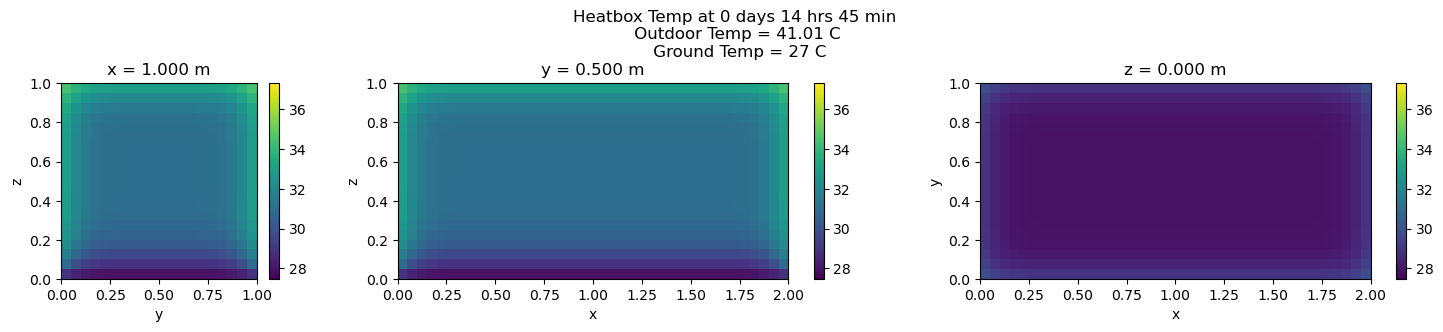

In [3]:
plotheatmaps(u,59,xmid,ymid,0)

I can show an animated version of the above (except, I'll take the horizontal slice to be in the middle of the heatbox). 

![](heatboxViz.gif)

## Compare interior temperature to exterior temp

In some sense, I feel like this should end up behaving like a driven harmonic oscillator (ish). That is the interior temp should lag behind the exterior temp after a fashion. I'll look at some average box temps.

In [4]:
boxTemp = np.zeros(tmax)
boxTempZ = np.zeros((tmax,zmax))
for l in range(tmax):
    ul = u[l, :, :, :]
    boxTemp[l] = np.mean(ul)
    for k in range(zmax):
        ulk = ul[:,:,k]
        boxTempZ[l,k] = np.mean(ulk)

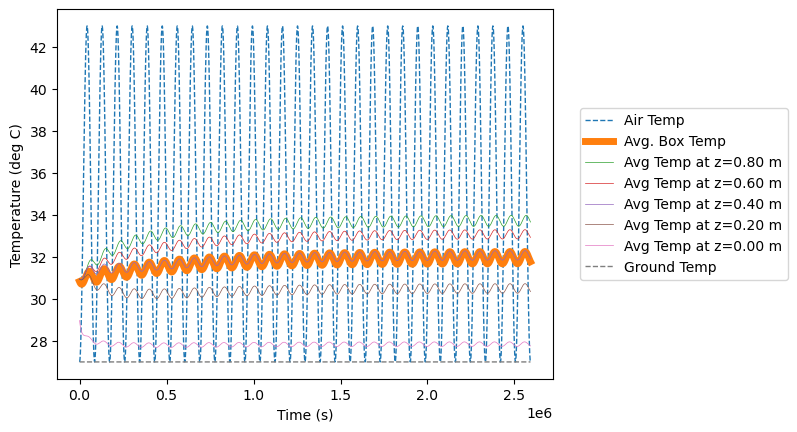

In [5]:
plt.plot(t,vair,label="Air Temp",ls='dashed',linewidth=1)
plt.plot(t,boxTemp, label="Avg. Box Temp",linewidth=5)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (deg C)')
for k in reversed(range(0,zmax,zmax//5)):
    zval = k*Deltax
    labString = f"Avg Temp at z={zval:.2f} m"
    plt.plot(t,boxTempZ[:,k], label=labString, linewidth=0.5)
plt.plot(t,vground,label="Ground Temp",ls="dashed",linewidth=1)
plt.legend(loc="center left", bbox_to_anchor=(1.04,0.5))
plt.show()

## Summary

This is working as a proof of concept. Yay, I can model an object using the heat equation.

My future plans:

- Make the ambient temperature higher on the sunny side.
- Add a window.
- Make this house/hut sized and add a wall. I may even take measurements of my house and
- Add in heating and cooling.

I don't think that blackbody radiation is important as the temps just aren't that high (we usually save that for Astronomy). I may do some back of the envelope math to confirm this in a later post.

In [6]:
x = np.linspace(0,10,11)
x[2:4]

array([2., 3.])

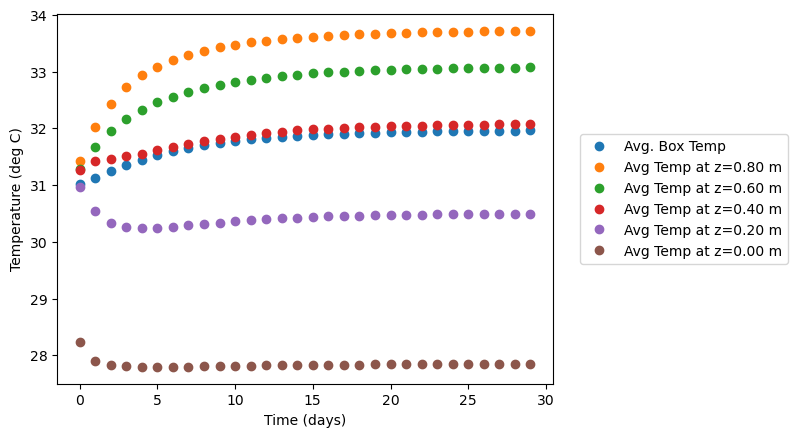

In [39]:
stepsInDay = int(oneDay/Deltat)
days = int(T/oneDay)
day = np.arange(0,days)

boxTempDay = np.zeros(days)
boxTempDayZ = np.zeros((days,zmax))
for d in range(days):
    lmin = int(d*stepsInDay)
    lmax = int((d+1)*stepsInDay)
    ul = u[lmin:lmax, :, :, :]
    boxTempDay[d] = np.mean(ul)
    for k in range(zmax):
        ulk = ul[:,:,:,k]
        boxTempDayZ[d,k] = np.mean(ulk)

plt.plot(day,boxTempDay,'o', label="Avg. Box Temp")
plt.xlabel('Time (days)')
plt.ylabel('Temperature (deg C)')
for k in reversed(range(0,zmax,zmax//5)):
    zval = k*Deltax
    labString = f"Avg Temp at z={zval:.2f} m"
    plt.plot(day,boxTempDayZ[:,k],'o', label=labString,)
    
plt.legend(loc="center left", bbox_to_anchor=(1.04,0.5))
plt.show()

In [35]:
u.shape

(2880, 40, 20, 20)

In [18]:
u[lmin:lmax,0,0,0]

array([27.89533777, 27.88383823, 27.87638876, 27.87302129, 27.87375025,
       27.87857253, 27.88746746, 27.90039693, 27.91730554, 27.93812085,
       27.96275366, 27.99109843, 28.02303368, 28.0584226 , 28.09711352,
       28.13894067, 28.1837248 , 28.23127403, 28.2813846 , 28.33384179,
       28.38842081, 28.44488779, 28.50300077, 28.56251073, 28.62316267,
       28.68469669, 28.74684911, 28.80935361, 28.87194236, 28.93434715,
       28.99630058, 29.05753718, 29.11779454, 29.17681446, 29.23434404,
       29.29013675, 29.34395353, 29.39556376, 29.44474629, 29.49129039,
       29.53499659, 29.57567763, 29.61315917, 29.64728062, 29.67789576,
       29.70487342, 29.72809798, 29.74746993, 29.76290627, 29.77434085,
       29.78172469, 29.78502614, 29.78423106, 29.77934287, 29.77038251,
       29.75738839, 29.74041618, 29.71953863, 29.6948452 , 29.66644172,
       29.63444988, 29.5990068 , 29.56026435, 29.51838856, 29.47355887,
       29.42596738, 29.37581804, 29.32332575, 29.26871544, 29.21

In [19]:
ul[:,0,0,0]

array([27.89533777, 27.88383823, 27.87638876, 27.87302129, 27.87375025,
       27.87857253, 27.88746746, 27.90039693, 27.91730554, 27.93812085,
       27.96275366, 27.99109843, 28.02303368, 28.0584226 , 28.09711352,
       28.13894067, 28.1837248 , 28.23127403, 28.2813846 , 28.33384179,
       28.38842081, 28.44488779, 28.50300077, 28.56251073, 28.62316267,
       28.68469669, 28.74684911, 28.80935361, 28.87194236, 28.93434715,
       28.99630058, 29.05753718, 29.11779454, 29.17681446, 29.23434404,
       29.29013675, 29.34395353, 29.39556376, 29.44474629, 29.49129039,
       29.53499659, 29.57567763, 29.61315917, 29.64728062, 29.67789576,
       29.70487342, 29.72809798, 29.74746993, 29.76290627, 29.77434085,
       29.78172469, 29.78502614, 29.78423106, 29.77934287, 29.77038251,
       29.75738839, 29.74041618, 29.71953863, 29.6948452 , 29.66644172,
       29.63444988, 29.5990068 , 29.56026435, 29.51838856, 29.47355887,
       29.42596738, 29.37581804, 29.32332575, 29.26871544, 29.21

In [31]:
tst = ul==u[lmin:lmax,:,:,:]

In [32]:
tst.all()

True

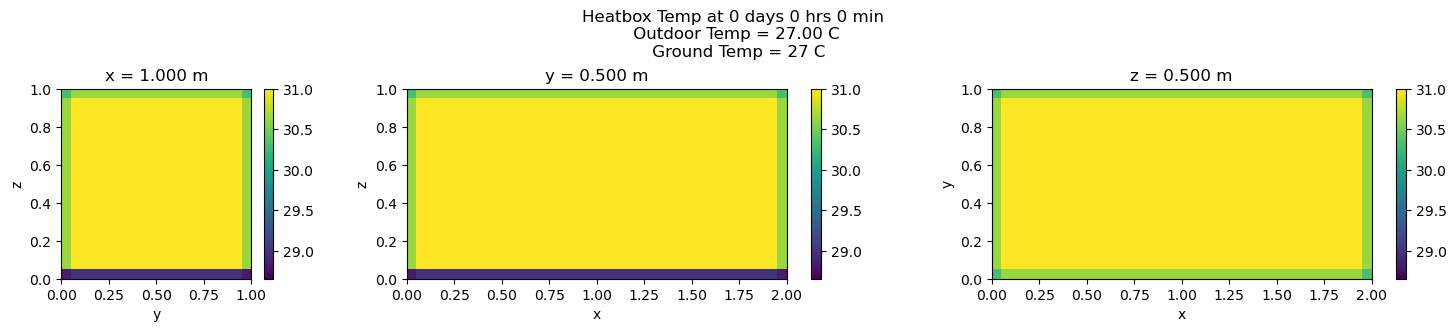

In [6]:
def plotheatmaps(u,l,i,j,k):
    Tmin = u.min()
    Tmax = u.max()
    
    xSlice = u[l,i,:,:].reshape(ymax,zmax).transpose()
    ySlice = u[l,:,j,:].reshape(xmax,zmax).transpose()
    zSlice = u[l,:,:,k].reshape(xmax,ymax).transpose()
    
    
    time = Deltat*l
    tMins = time // 60
    theMinutes = tMins % 60
    
    tHours = tMins // 60
    theDays = tHours // 24
    theHours = tHours % 24
    
    theTime = str(theDays) + " days " + str(theHours) + " hrs "  + str(theMinutes) + " min"

    xC, yC, zC = [Deltax*i, Deltax*j, Deltax*k]
    
    fig, (ax0,ax1,ax2) = plt.subplots(ncols=3,width_ratios=[W,L,L],figsize=(15,3))
    
    fig.suptitle(f"Heatbox Temp at {theTime} \n Outdoor Temp = {vair[l]:.2f} C \n Ground Temp = {vground[l]:.0f} C")
    
    im = ax0.pcolormesh(ygrid, zgrid, xSlice, shading="flat", vmin = Tmin, vmax = Tmax)
    ax0.set_aspect(1)
    ax0.set_title(f"x = {xC:.3f} m")
    ax0.set_xlabel("y")
    ax0.set_ylabel("z")
    fig.colorbar(im, ax = ax0)
    
    ax1.pcolormesh(xgrid, zgrid, ySlice, shading="flat", vmin = Tmin, vmax = Tmax)
    ax1.set_aspect(1)
    ax1.set_title(f"y = {yC:.3f} m")
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")
    fig.colorbar(im, ax = ax1)
    
    ax2.pcolormesh(xgrid, ygrid, zSlice, shading="flat", vmin = Tmin, vmax = Tmax)
    ax2.set_aspect(1)
    ax2.set_title(f"z = {zC:.3f} m")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    fig.colorbar(im, ax = ax2)
    
    fig.tight_layout()
    
plotheatmaps(u,0,xmid,ymid,zmid)